<a href="https://colab.research.google.com/github/adrian-lison/gnn-community-detection/blob/master/Notebooks/KarateCora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Karate Cora


In [0]:
%matplotlib inline
!pip install dgl

     |████████████████████████████████| 2.4MB 5.1MB/s 


In [0]:
from dgl.data import citation_graph as citegrh
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import time
import numpy as np

In [0]:
#Loading CORA
data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labelsCORA = th.LongTensor(data.labels)
mask = th.ByteTensor(data.train_mask)
g = data.graph
# removing doesnt work
#g.remove_edges_from(g.selfloop_edges())
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

Extracting file to /root/.dgl/cora


In [0]:
G = g
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 2708 nodes.
We have 13264 edges.


In [0]:
import torch
#number of nodes
G.ndata['feat'] = torch.eye(2708)

In [0]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

tensor([[0., 0., 1.,  ..., 0., 0., 0.]])


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [0]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(2708, 21, 7)

In [0]:
import random as rng

def get_label(x):
  return(int(labelsCORA[x]))

#Percentage of nodes known for training
percentage_open_nodes = 0.02
graph_node_size = int(G.number_of_nodes())
open_nodes = rng.sample(range(0,graph_node_size),int(graph_node_size*percentage_open_nodes))
open_nodes_labels = list(map(get_label,open_nodes))
len(open_nodes)

54

In [0]:
inputs = torch.eye(graph_node_size)
labeled_nodes = torch.tensor(open_nodes)  #
labels = torch.tensor(open_nodes_labels)  # 

In [0]:
#Helper to print accuracy
def output_accuracy(i,logits0):
  all_logits = logits0
  labels_final = []

  for v in range(graph_node_size):
    calculated_label = all_logits[i][v].numpy().argmax()
    labels_final.append(calculated_label)
  n_correct = 0
  n_correct_random = 0
  for v in range(graph_node_size):
    if (labels_final[v] == int(labelsCORA[v])):
      n_correct +=1
    if (int(rng.randrange(0,6)) == int(labelsCORA[v])):
      n_correct_random +=1
  print("Accuracy with " + str(int(percentage_open_nodes*100)) + "% labeld nodes: " + str(n_correct/graph_node_size) + " including " + str(int(graph_node_size*percentage_open_nodes)) + " prelabeld nodes. Excluding: " + str((n_correct-len(open_nodes))/(graph_node_size-len(open_nodes))) )

In [0]:
net = GCN(2708, 21, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    val_loss = F.nll_loss(logp.detach(), labelsCORA)
    #val_loss=torch.tensor(42)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f | Total: %.4f' % (epoch, loss.item(), val_loss.item()))
    output_accuracy(epoch,all_logits)

Epoch 0 | Loss: 1.9442 | Total: 1.9397
Accuracy with 2% labeld nodes: 0.15103397341211225 including 54 prelabeld nodes. Excluding: 0.13376036171816127
Epoch 1 | Loss: 1.6460 | Total: 1.7872
Accuracy with 2% labeld nodes: 0.3430576070901034 including 54 prelabeld nodes. Excluding: 0.3296910324039186
Epoch 2 | Loss: 1.3463 | Total: 1.6392
Accuracy with 2% labeld nodes: 0.4623338257016248 including 54 prelabeld nodes. Excluding: 0.45139412207987945
Epoch 3 | Loss: 1.1084 | Total: 1.5486
Accuracy with 2% labeld nodes: 0.49704579025110784 including 54 prelabeld nodes. Excluding: 0.48681235870384326
Epoch 4 | Loss: 0.9259 | Total: 1.5068
Accuracy with 2% labeld nodes: 0.516248153618907 including 54 prelabeld nodes. Excluding: 0.506405425772419
Epoch 5 | Loss: 0.7810 | Total: 1.4945
Accuracy with 2% labeld nodes: 0.5398818316100443 including 54 prelabeld nodes. Excluding: 0.5305199698568199
Epoch 6 | Loss: 0.6578 | Total: 1.4977
Accuracy with 2% labeld nodes: 0.551698670605613 including 54 pr

In [0]:
#Access to calculated logits per epoch and node
#epoch #node
all_logits[4][2000].numpy()
all_logits[4][2500].numpy().argmax()
all_logits[4][33]

tensor([-0.2086, -0.2048,  0.4877, -0.0416, -0.2286, -0.3503,  0.0758])

In [0]:
#Create PCA feature transformation based on last epoch
final = 49
features_final = {}

for v in range(graph_node_size):
  features_final[v] = all_logits[final][v].numpy()

In [0]:
#Show final features of first node
import pandas as pd
df = pd.DataFrame.from_dict(features_final,orient='index')
df.head(1)

,0,1,2,3,4,5,6
0,-5.667466,-1.054757,3.05605,0.079027,-0.869008,-2.964351,-1.68857


In [0]:
# Scaling before PCA
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 

X_train = sc.fit_transform(df) 

# Applying PCA function on training 
# and testing set of X component 
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 2) 
  
X_train = pca.fit_transform(X_train) 
#X_test = pca.transform(X_test) 
  
explained_variance = pca.explained_variance_ratio_ 
explained_variance

array([0.47364775, 0.27762036])

In [0]:
#Apply to the previously calculated model
def tranform_with_pca(logits):
  X_test = sc.transform(pd.DataFrame(logits).transpose()) 
  X_test = pca.transform(X_test) 
  return(X_test[0])

In [0]:
#Method to normalize a dataframe
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [0]:
#Postions per epoch for PCA
pos_epochs = {}
for x in range(final+1):
  pos2d = {}
  for v in range(graph_node_size):
    pos2d[v] =  tranform_with_pca(all_logits[x][v].numpy())
  df = (pd.DataFrame(pos2d)).transpose()
  df_normalized = normalize(df)
  #Apply 0.35 Root to make outliers smaller
  df_normalized = df_normalized.applymap(lambda x : x**0.35)
  pos_epochs[x] = df_normalized

In [0]:
#You could also use this for transforming and reducing outliers
import math
def fake_log(x):
  base = 1.5
  if (x == 0):
    return(0)
  if (x < 0):
    return(math.log((x*-1),base)*-1)
  else:
    return(math.log(x,base))

In [0]:
#Alternative: Create positions with tsne for ONE epoch
from sklearn.manifold import TSNE

pos_epochs[final] = pd.DataFrame(TSNE(n_components=2,n_iter=250).fit_transform(all_logits[final].numpy()))

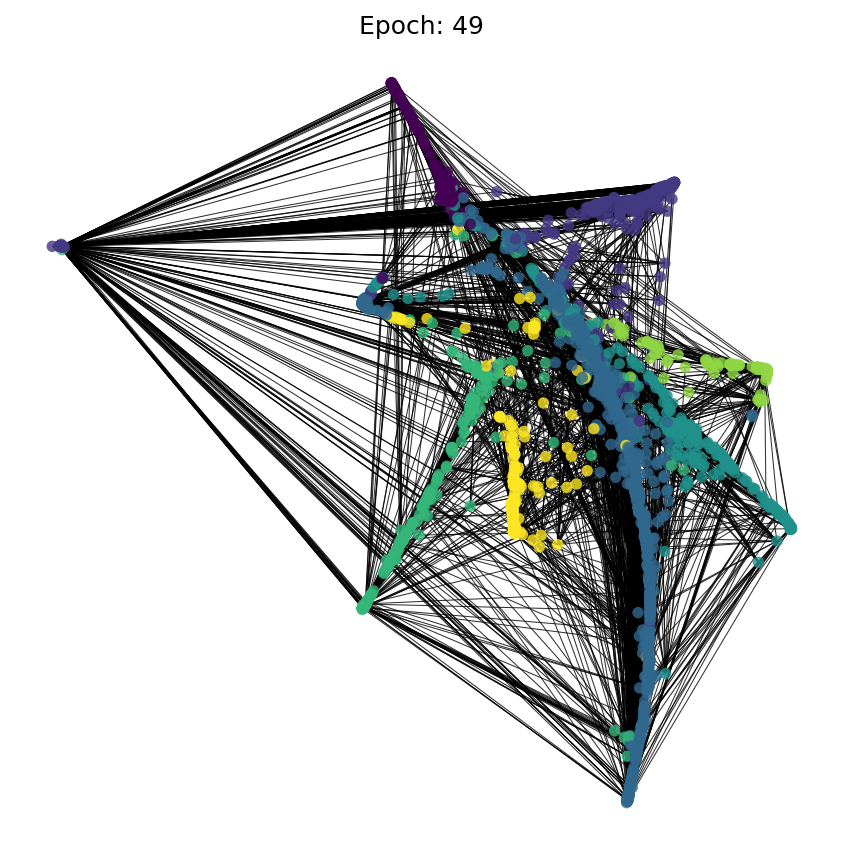

In [0]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
nx_G = G.to_networkx().to_undirected()

def draw(i):
    #cls1color = '#00FFFF'
    #cls2color = '#FF00FF'
    pos = {}
    pos2d = {}
    colors = []
    for v in range(graph_node_size):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        #Toggle next rows
        #pos2d[v] =  tranform_with_pca(pos[v])
        #pos2d[v] = df_normalized.loc[[v]].values[0]
        pos2d[v] = pos_epochs[i].loc[[v]].values[0]
        colors.append(cls)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos=pos2d , node_color=colors,
            with_labels=False, node_size=30, ax=ax, width=0.5, alpha=0.8, linewidths=0)

fig = plt.figure(dpi=150,figsize=(7, 7))
fig.clf()
ax = fig.subplots()
draw(49)  # draw the prediction of the first epoch
#plt.close()

In [0]:
#ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=100)
ani = animation.FuncAnimation(fig, draw, frames=final+1, interval=100)
ani = ani.to_html5_video()
from IPython.display import HTML
HTML(ani)